In [30]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split

import src.data_processing as dp
import src.feature_engineering as fe
import src.feature_processor as fp
import src.model as m

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Load data
train_path = '../data/train.xlsx'
test_path = '../data/test.xlsx'

train_data_raw, test_data_raw = pd.read_excel(train_path), pd.read_excel(test_path)


array([[<Axes: title={'center': 'competitor_lowest_price'}>]],
      dtype=object)

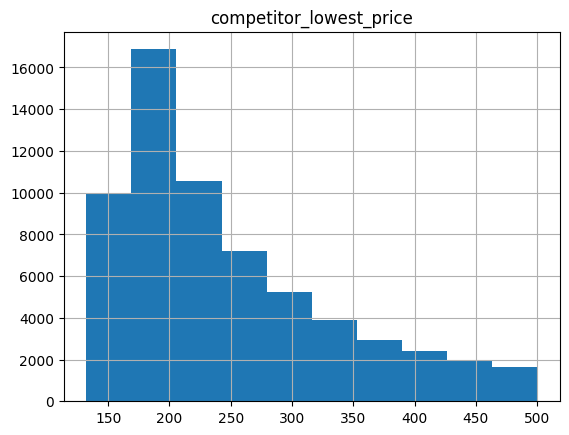

In [34]:
train_data_raw.hist("competitor_lowest_price")

In [56]:
train_processed["vehicle_age"]

9433      5.585216
50781     0.670773
9313      1.913758
52766    21.084189
29933     7.501711
           ...    
62570    16.167009
38158    17.166324
860       9.418207
15795     5.837098
56422     6.417522
Name: vehicle_age, Length: 50159, dtype: float64

In [63]:
train_data.vehicle_number_of_doors.dtype

dtype('int64')

In [72]:
# Split training data for validation
train_data, val_data = train_test_split(
    train_data_raw, 
    test_size=0.2, 
    random_state=42
)

feature_processor = fp.FeatureProcessor()
pricing_model = m.PricingModel()


# Fit and transform training data
train_processed = feature_processor.fit_transform(train_data)

# Transform validation and test data using training statistics
val_processed = feature_processor.transform(val_data)
test_processed = feature_processor.transform(test_data_raw)


In [68]:
# Check for NaN or None values in the processed training data
print("Checking for NaN values in train_processed:")
nan_counts = train_processed.isna().sum()
print(f"Total NaN values: {nan_counts.sum()}")

# Display columns with NaN values (if any)
if nan_counts.sum() > 0:
    print("\nColumns with NaN values:")
    print(nan_counts[nan_counts > 0])

# Check for None values (which might not be caught by isna())
none_counts = train_processed.applymap(lambda x: x is None).sum()
print(f"\nTotal None values: {none_counts.sum()}")

# Display columns with None values (if any)
if none_counts.sum() > 0:
    print("\nColumns with None values:")
    print(none_counts[none_counts > 0])

# Visualize missing values if there are any
if nan_counts.sum() > 0 or none_counts.sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.heatmap(train_processed.isna(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Missing Values in train_processed')
    plt.tight_layout()
    plt.show()


Checking for NaN values in train_processed:
Total NaN values: 0

Total None values: 0


/var/folders/7x/qgn219m96711nt4bv8k3tgtr0000gn/T/ipykernel_21469/199306444.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  none_counts = train_processed.applymap(lambda x: x is None).sum()


In [73]:


# Prepare data for model
X_train = train_processed.drop(['quote_id', 'competitor_lowest_price'], axis=1)
y_train = train_processed['competitor_lowest_price']

X_val = val_processed.drop(['quote_id', 'competitor_lowest_price'], axis=1)
y_val = val_processed['competitor_lowest_price']

# Train model
pricing_model._train_base_models(X_train, y_train, X_val, y_val)

[0]	train-quantile:9.30251	val-quantile:9.41350
[100]	train-quantile:6.91199	val-quantile:7.23035
[200]	train-quantile:6.67521	val-quantile:7.12771
[300]	train-quantile:6.59522	val-quantile:7.10860
[400]	train-quantile:6.53379	val-quantile:7.09939
[444]	train-quantile:6.51571	val-quantile:7.09934
[0]	train-quantile:23.64939	val-quantile:23.89528
[100]	train-quantile:15.25485	val-quantile:15.87991
[200]	train-quantile:14.71065	val-quantile:15.63752
[300]	train-quantile:14.42399	val-quantile:15.58726
[400]	train-quantile:14.21644	val-quantile:15.55492
[500]	train-quantile:14.08202	val-quantile:15.54215
[600]	train-quantile:13.94346	val-quantile:15.53482
[700]	train-quantile:13.83340	val-quantile:15.52805
[800]	train-quantile:13.75684	val-quantile:15.52629
[806]	train-quantile:13.75132	val-quantile:15.52538
[0]	train-quantile:32.36584	val-quantile:32.82252
[100]	train-quantile:18.68776	val-quantile:19.38562
[200]	train-quantile:18.02236	val-quantile:19.12866
[300]	train-quantile:17.65475	

In [ ]:
train_loss = evals_result['train']['quantileerror']
val_loss = evals_result['val']['quantileerror']
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.xlabel("Boosting Round")
plt.ylabel("Quantile Loss")
plt.title("Learning Curves")
plt.legend()
plt.grid(True)
plt.show()

In [75]:
# Val prediction

# Calculate and print metrics for training set
val_predictions = pricing_model.base_models[0.7].predict(xgb.DMatrix(X_val))
has_sold = y_val > val_predictions
sold_policies = val_predictions[has_sold]
actual_prices = y_val[has_sold]

avg_loss = (actual_prices - sold_policies).mean()
market_share = has_sold.mean()

print(f"Training Metrics:")
print(f"Average Loss: {avg_loss:.2f}")
print(f"Market Share: {market_share:.2%}")

Training Metrics:
Average Loss: 38.44
Market Share: 31.20%


Top 15 most important features for median (0.5) quantile model:


,Feature,Importance
0,number_of_competitors,15.568311
1,vehicle_acquisition_state_OWNED,5.426506
2,total_claims,4.449480
3,vehicle_acquisition_state_RECENT_SECOND_HAND_F...,4.437463
4,vehicle_acquisition_state_RECENT_SECOND_HAND_F...,3.612950
5,vehicle_acquisition_state_RECENT_FIRST_HAND,3.567328
6,driver_insured_years,3.558907
7,experience_ratio,3.292117
8,driving_experience,3.182695
9,vehicle_age,2.417148


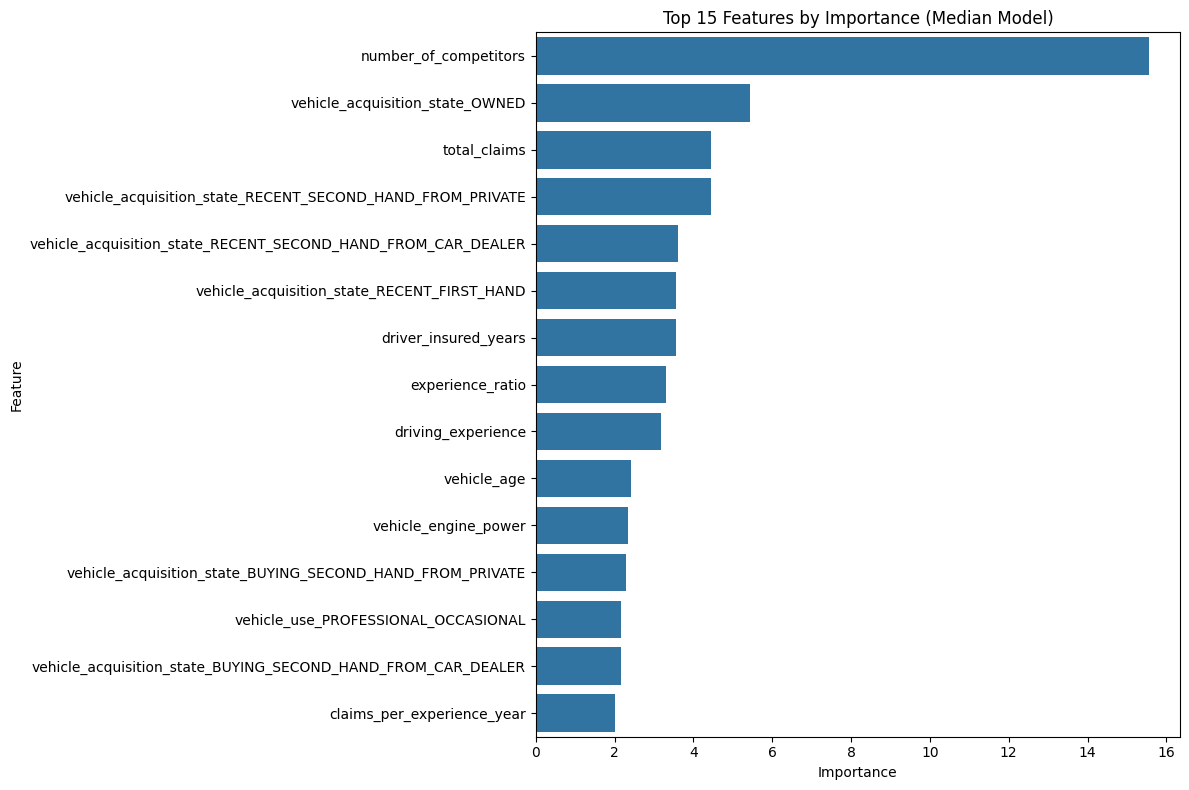

Bottom 15 least important features for median (0.5) quantile model:


,Feature,Importance
23,vehicle_use_HABITUAL,1.308012
24,vehicle_use_OCCASIONAL,1.305353
25,driver_other_vehicles_BIKE,1.261427
26,quote_hour,1.219926
27,vehicle_use_PROFESSIONAL_HABITUAL,1.191981
28,quote_day_of_week,1.161965
29,recent_claims,1.120152
30,policyholder_license_attainment_age,1.056625
31,policyholder_age,1.001317
32,driver_claims_from_year_2_to_3,0.959105


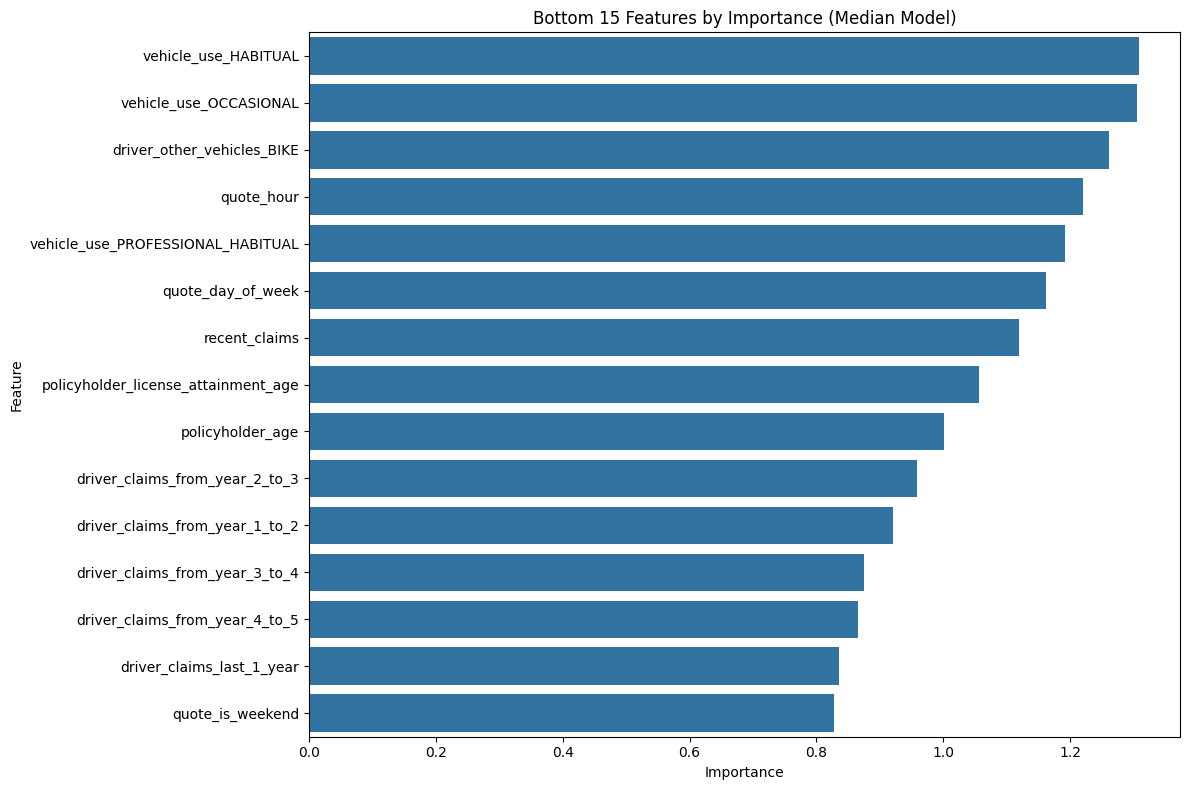

<Figure size 1400x1000 with 0 Axes>

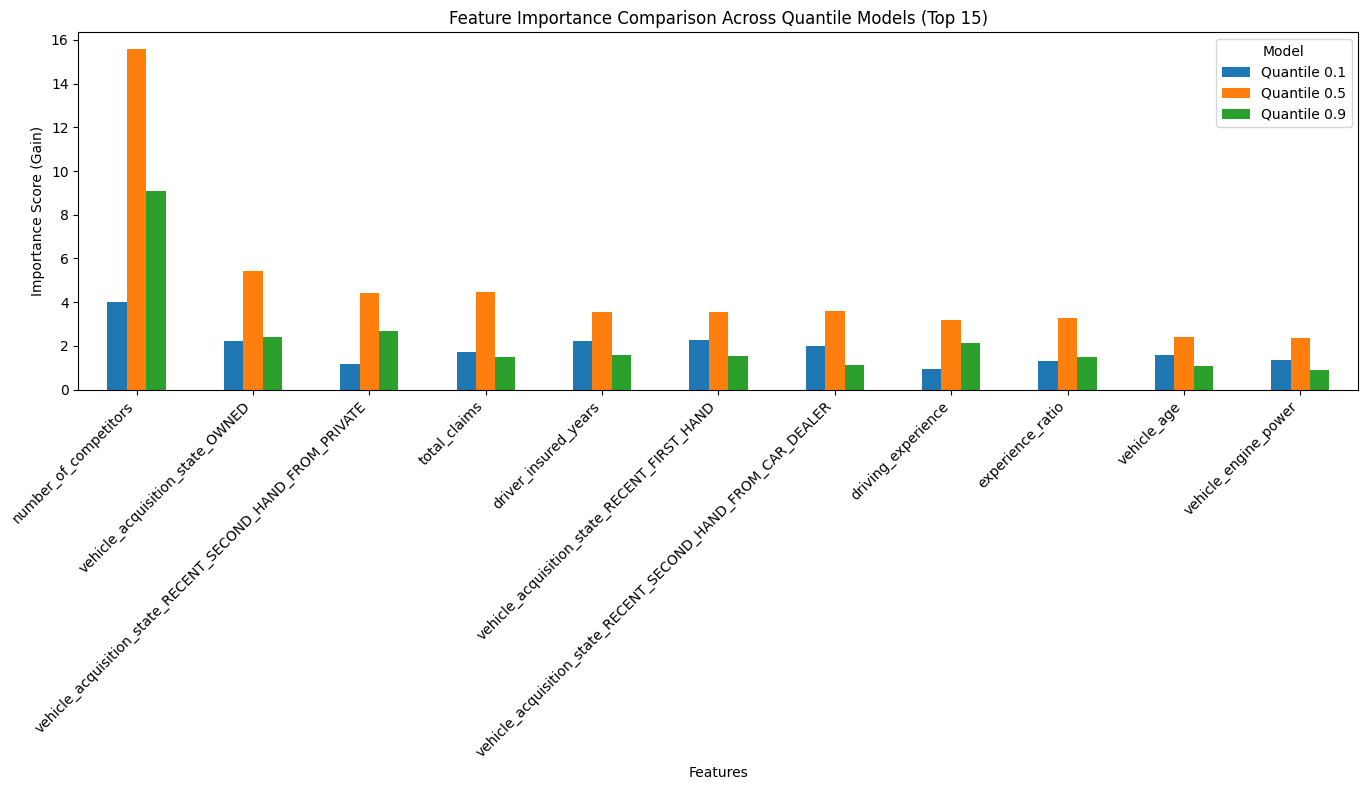

<Figure size 1400x1000 with 0 Axes>

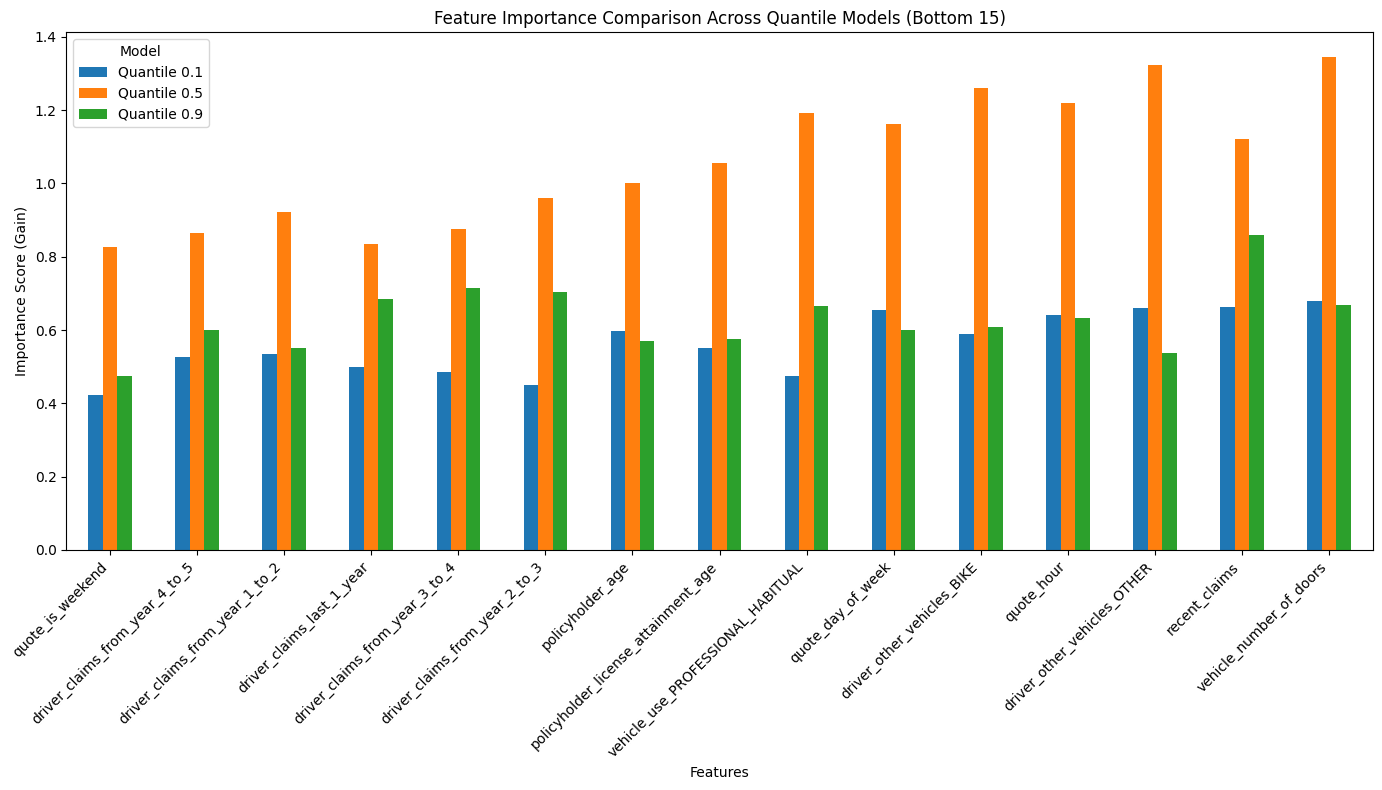

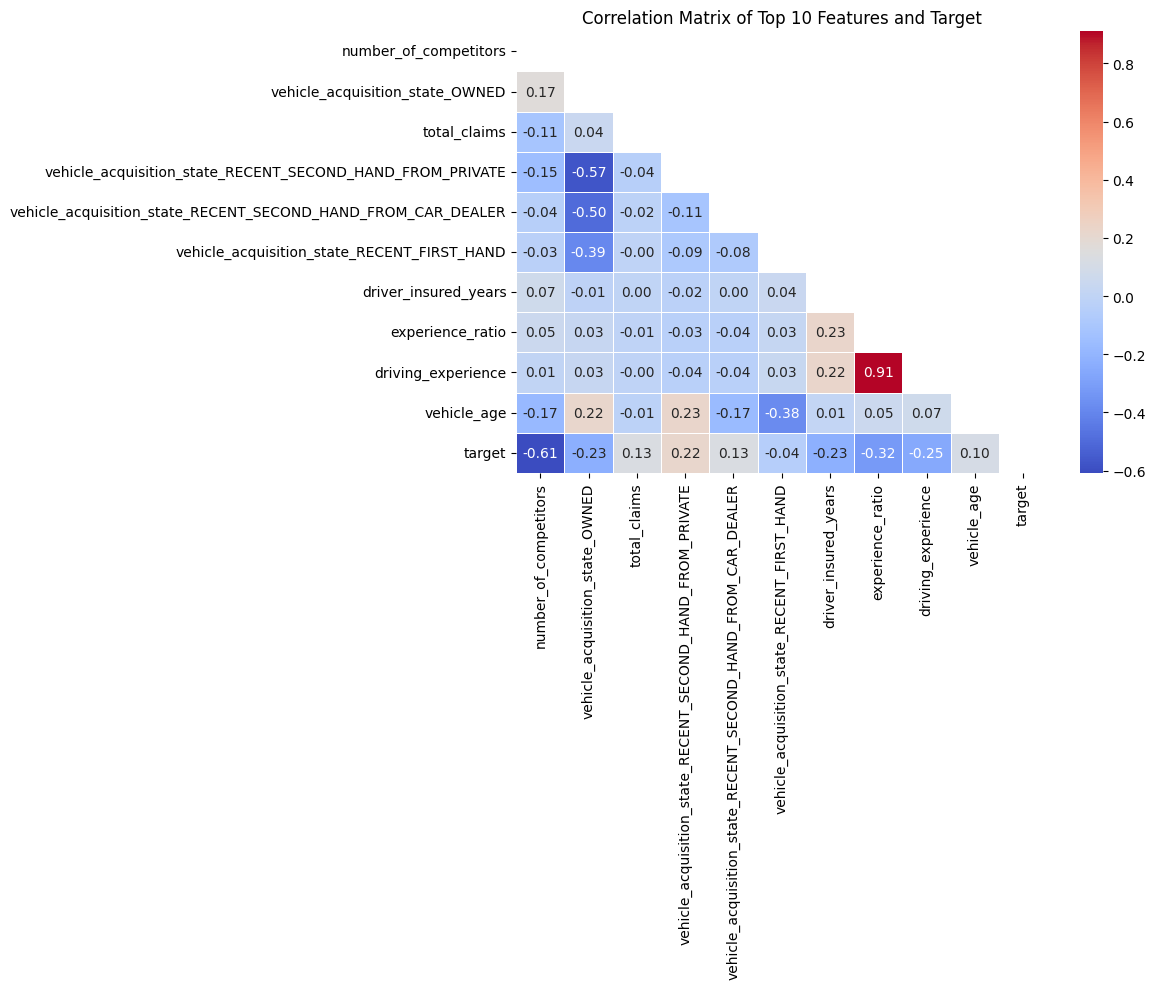

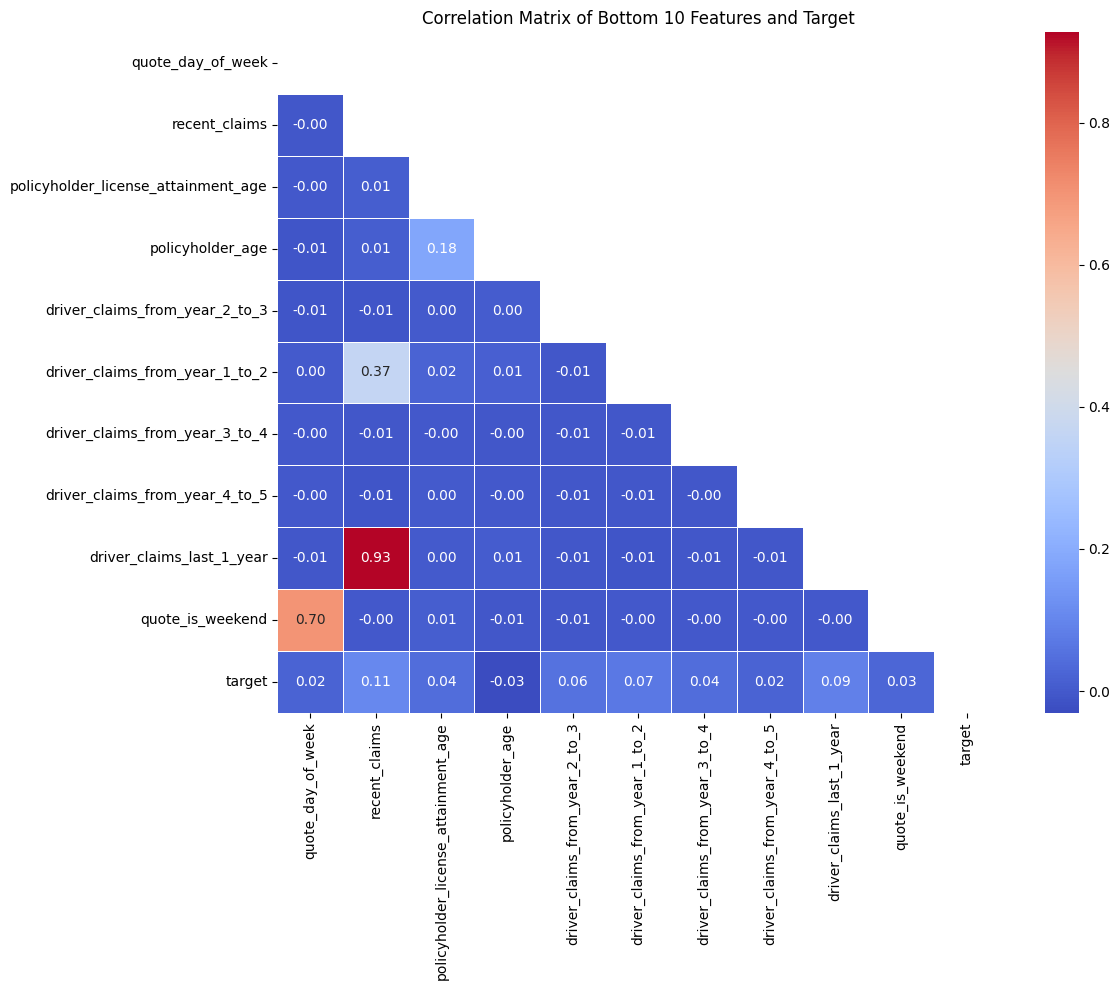

In [70]:
# Analyze feature importance in the base models
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get feature importance from a model
def get_feature_importance(model, feature_names):
    importance_scores = model.get_score(importance_type='gain')
    # Convert to DataFrame for easier manipulation
    importance_df = pd.DataFrame({
        'Feature': list(importance_scores.keys()),
        'Importance': list(importance_scores.values())
    })
    
    # Map F0, F1, etc. to actual feature names if needed
    if 'F0' in importance_df['Feature'].values:
        feature_map = {f'F{i}': name for i, name in enumerate(feature_names)}
        importance_df['Feature'] = importance_df['Feature'].map(lambda x: feature_map.get(x, x))
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    return importance_df

# Get feature importance for each quantile model
feature_importances = {}
for quantile, model in pricing_model.base_models.items():
    feature_importances[quantile] = get_feature_importance(model, X_train.columns)

# Display top 15 features for the median (0.5) quantile model
print("Top 15 most important features for median (0.5) quantile model:")
display(feature_importances[0.5].head(15))

# Plot feature importance for the median model
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances[0.5].head(15))
plt.title('Top 15 Features by Importance (Median Model)')
plt.tight_layout()
plt.show()

# Display bottom 15 features for the median (0.5) quantile model
print("Bottom 15 least important features for median (0.5) quantile model:")
display(feature_importances[0.5].tail(15))

# Plot feature importance for the bottom features in the median model
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances[0.5].tail(15))
plt.title('Bottom 15 Features by Importance (Median Model)')
plt.tight_layout()
plt.show()

# Compare feature importance across different quantile models
# Get top 10 features from each model
top_features = set()
for quantile in pricing_model.base_models.keys():
    top_features.update(feature_importances[quantile].head(10)['Feature'].tolist())

# Create a comparison dataframe
comparison_df = pd.DataFrame(index=list(top_features))
for quantile in pricing_model.base_models.keys():
    temp_df = feature_importances[quantile].set_index('Feature')['Importance']
    comparison_df[f'Quantile {quantile}'] = temp_df

# Fill NaN with 0 (features not in top 10 for a particular quantile)
comparison_df = comparison_df.fillna(0)

# Sort by average importance across quantiles
comparison_df['Average'] = comparison_df.mean(axis=1)
comparison_df = comparison_df.sort_values('Average', ascending=False)
comparison_df = comparison_df.drop('Average', axis=1)

# Plot comparison
plt.figure(figsize=(14, 10))
comparison_df.head(15).plot(kind='bar', figsize=(14, 8))
plt.title('Feature Importance Comparison Across Quantile Models (Top 15)')
plt.ylabel('Importance Score (Gain)')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Get bottom 15 features from each model
bottom_features = set()
for quantile in pricing_model.base_models.keys():
    bottom_features.update(feature_importances[quantile].tail(15)['Feature'].tolist())

# Create a comparison dataframe for bottom features
bottom_comparison_df = pd.DataFrame(index=list(bottom_features))
for quantile in pricing_model.base_models.keys():
    temp_df = feature_importances[quantile].set_index('Feature')['Importance']
    bottom_comparison_df[f'Quantile {quantile}'] = temp_df

# Fill NaN with 0 (features not in bottom 15 for a particular quantile)
bottom_comparison_df = bottom_comparison_df.fillna(0)

# Sort by average importance across quantiles (ascending for bottom features)
bottom_comparison_df['Average'] = bottom_comparison_df.mean(axis=1)
bottom_comparison_df = bottom_comparison_df.sort_values('Average', ascending=True)
bottom_comparison_df = bottom_comparison_df.drop('Average', axis=1)

# Plot comparison for bottom features
plt.figure(figsize=(14, 10))
bottom_comparison_df.head(15).plot(kind='bar', figsize=(14, 8))
plt.title('Feature Importance Comparison Across Quantile Models (Bottom 15)')
plt.ylabel('Importance Score (Gain)')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Analyze correlation between top features and target
top_10_features = feature_importances[0.5].head(10)['Feature'].tolist()
correlation_df = X_train[top_10_features].copy()
correlation_df['target'] = y_train.values

plt.figure(figsize=(12, 10))
correlation_matrix = correlation_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Top 10 Features and Target')
plt.tight_layout()
plt.show()

# Analyze correlation between bottom features and target
bottom_10_features = feature_importances[0.5].tail(10)['Feature'].tolist()
bottom_correlation_df = X_train[bottom_10_features].copy()
bottom_correlation_df['target'] = y_train.values

plt.figure(figsize=(12, 10))
bottom_correlation_matrix = bottom_correlation_df.corr()
bottom_mask = np.triu(np.ones_like(bottom_correlation_matrix, dtype=bool))
sns.heatmap(bottom_correlation_matrix, mask=bottom_mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Bottom 10 Features and Target')
plt.tight_layout()
plt.show()


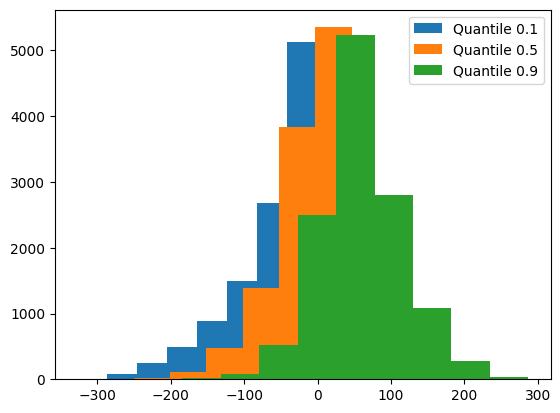

In [41]:
f, ax = plt.subplots(1, 1)

quantile_preds = {}


for quantile, model_ in pricing_model.base_models.items():
    preds = model_.predict(xgb.DMatrix(X_val))
    quantile_preds[quantile] = preds
    errors = preds - y_val
    ax.hist(errors, label=f'Quantile {quantile}')
ax.legend()

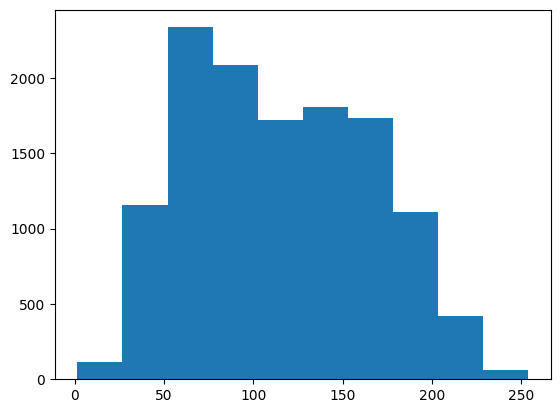

In [ ]:
plt.hist(quantile_preds[0.9] - quantile_preds[0.1]);



In [88]:
q10_pred = pricing_model.base_models[0.1].predict(xgb.DMatrix(X_train))
q30_pred = pricing_model.base_models[0.3].predict(xgb.DMatrix(X_train))
q50_pred = pricing_model.base_models[0.5].predict(xgb.DMatrix(X_train))
q70_pred = pricing_model.base_models[0.7].predict(xgb.DMatrix(X_train))
q90_pred = pricing_model.base_models[0.9].predict(xgb.DMatrix(X_train))

q10_pred_val = pricing_model.base_models[0.1].predict(xgb.DMatrix(X_val))
q30_pred_val = pricing_model.base_models[0.3].predict(xgb.DMatrix(X_val))
q50_pred_val = pricing_model.base_models[0.5].predict(xgb.DMatrix(X_val))
q70_pred_val = pricing_model.base_models[0.7].predict(xgb.DMatrix(X_val))
q90_pred_val = pricing_model.base_models[0.9].predict(xgb.DMatrix(X_val))

lambdas = np.linspace(-1, 1, 100)
avg_losses = []
market_shares = []
avg_losses_val = []
market_shares_val = []

for lambda_ in lambdas:
    preds = q70_pred + lambda_ * (q70_pred - q50_pred)
    preds_val = q70_pred_val + lambda_ * (q70_pred_val - q50_pred_val)
    # Calculate and print metrics for training set
    has_sold = y_train > preds
    sold_policies = preds[has_sold]
    actual_prices = y_train[has_sold]
    has_sold_val = y_val > preds_val
    sold_policies_val = preds_val[has_sold_val]
    actual_prices_val = y_val[has_sold_val]

    avg_loss = (actual_prices - sold_policies).mean()
    avg_loss_val = (actual_prices_val - sold_policies_val).mean()
    market_share = has_sold.mean()
    market_share_val = has_sold_val.mean()
    avg_losses.append(avg_loss)
    market_shares.append(market_share)
    avg_losses_val.append(avg_loss_val)
    market_shares_val.append(market_share_val)

    

In [128]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import numpy as np

PARAMETER_NAMES = ["number_of_competitors_prop", "total_claims_prop", "prediction_spread_relative_prop",
                   "number_of_competitors_norm_switch", "prediction_spread_relative_switch"]

class PricingOptimizationProblem(Problem):
    def __init__(self, pricing_model, X_train, y_train):
        super().__init__(n_var=5, n_obj=2, n_constr=0, xl=np.array([-1, -1, -1, -1, 0]), xu=np.array([1, 1, 1, 1, 1]))
        self.pricing_model = pricing_model
        self.X_train = X_train
        self.y_train = y_train
        
        # Get quantile predictions once to avoid recomputation
        self.q10_pred = pricing_model.base_models[0.1].predict(xgb.DMatrix(X_train))
        self.q30_pred = pricing_model.base_models[0.3].predict(xgb.DMatrix(X_train))
        self.q50_pred = pricing_model.base_models[0.5].predict(xgb.DMatrix(X_train))
        self.q70_pred = pricing_model.base_models[0.7].predict(xgb.DMatrix(X_train))
        self.q90_pred = pricing_model.base_models[0.9].predict(xgb.DMatrix(X_train))
        self.prediction_spread_relative = (self.q90_pred - self.q50_pred) / self.q70_pred

    
        self.number_of_competitors_norm = X_train["number_of_competitors"] / X_train["number_of_competitors"].max()
        self.total_claims_norm = X_train["total_claims"] / X_train["total_claims"].max()
        self.prediction_spread_relative_norm = self.prediction_spread_relative/self.prediction_spread_relative.max()

        self.coupling_competitors_claims = self.number_of_competitors_norm*self.total_claims_norm
        self.coupling_competitors_spread = self.prediction_spread_relative_norm*self.number_of_competitors_norm
        self.coupling_claims_spread = self.total_claims_norm*self.prediction_spread_relative_norm


        
    def _evaluate(self, x, out, *args, **kwargs):
        # Extract parameters
        f_values = np.zeros((len(x), 2))  # Two objectives: avg_loss and -market_share
        
        for i, params in enumerate(x):
            (prop_q30,
             prop_q50,
             prop_q70,
             prop_q90,
             prediction_spread_relative_norm_switch) = params
            
            adjusted_prices = prop_q30*self.q30_pred + prop_q50*self.q50_pred + prop_q70*self.q70_pred + prop_q90*self.q90_pred
            adjusted_prices = adjusted_prices +  1e6*(self.prediction_spread_relative_norm > prediction_spread_relative_norm_switch)
            
            
            # Calculate metrics
            has_sold = self.y_train > adjusted_prices
            market_share = has_sold.mean()
            
            if has_sold.sum() == 0:
                f_values[i, 0] = 1e6  # Large penalty for no sales
                f_values[i, 1] = 1.0  # Worst market share (0%)
            else:
                avg_loss = (self.y_train[has_sold] - 
                           adjusted_prices[has_sold]).mean()
                f_values[i, 0] = avg_loss
                f_values[i, 1] = -market_share  # Negative because we want to maximize market share
        
        out["F"] = f_values


In [131]:
# Create problem
problem = PricingOptimizationProblem(pricing_model, X_train, y_train)

# Configure algorithm
algorithm = NSGA2(
    pop_size=100,
    eliminate_duplicates=True
)

# Run optimization
res = minimize(problem,
                algorithm,
                ('n_gen', 100),
                seed=1,
                verbose=True)

    

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     15 |             - |             -
     2 |      200 |     21 |  0.0157419732 |             f
     3 |      300 |     25 |  0.0245525088 |         ideal
     4 |      400 |     34 |  0.1174675150 |         nadir
     5 |      500 |     33 |  0.0072157111 |             f
     6 |      600 |     44 |  0.7693602334 |         nadir
     7 |      700 |     50 |  0.0056220471 |             f
     8 |      800 |     54 |  0.0375298971 |         ideal
     9 |      900 |     66 |  0.0056722957 |             f
    10 |     1000 |     79 |  0.0023643729 |             f
    11 |     1100 |     92 |  0.0068629193 |         ideal
    12 |     1200 |    100 |  0.0012968798 |             f
    13 |     1300 |    100 |  0.0144671160 |         nadir
    14 |     1400 |    100 |  0.0025725842 |         nadir
    15 |     1500 |    100 |  0.0011821457 |             f
    16 |     1600 |    100 |  0.0022282622 |            

In [134]:
def metrics(prices, y):
    has_sold = y > prices
    market_share = has_sold.mean()
    avg_loss = (y[has_sold] - prices[has_sold]).mean()
    return avg_loss, market_share

baseline_loss, baseline_market_share = metrics(q70_pred_val, y_val)

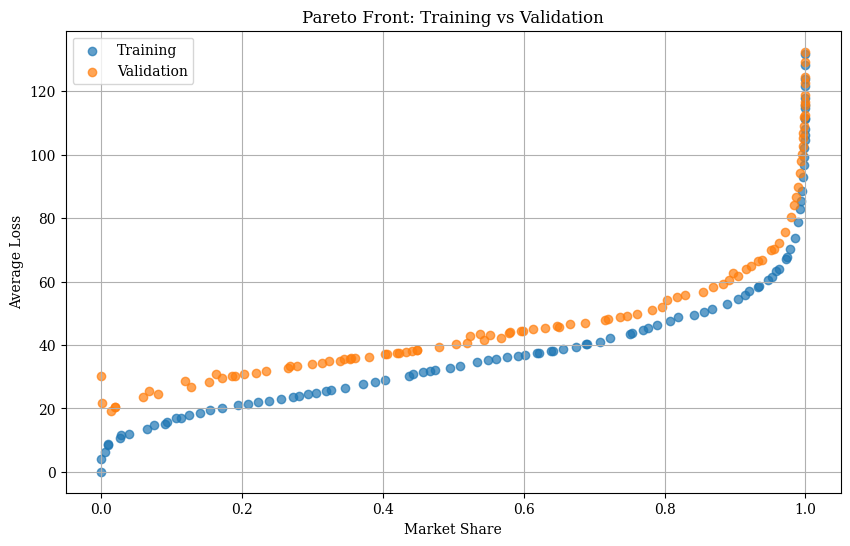

Top 5 solutions on validation set:
Solution 30: Market Share = 99.99%, Avg Loss = 129.23, Params = [ 0.97733603 -0.28703532 -0.32644279  0.19806128  0.98093386]
Solution 0: Market Share = 99.99%, Avg Loss = 132.50, Params = [ 0.93297351 -0.29152648 -0.30677526  0.20546459  0.97304817]
Solution 58: Market Share = 99.98%, Avg Loss = 124.68, Params = [ 0.97733603 -0.27685014 -0.31855285  0.19806128  0.98093386]
Solution 22: Market Share = 99.97%, Avg Loss = 122.49, Params = [ 0.89789162 -0.2869894  -0.27881225  0.23509778  0.9944749 ]
Solution 93: Market Share = 99.95%, Avg Loss = 116.51, Params = [ 0.89789162 -0.2869894  -0.15453443  0.14722656  0.9944749 ]


In [133]:
from pymoo.visualization.scatter import Scatter

Scatter().add(res.F).show()

# Evaluate solutions on validation set
val_f_values = np.zeros((len(res.X), 2))

for i, params in enumerate(res.X):
    (prop_q30, prop_q50, prop_q70, prop_q90, 
     prediction_spread_relative_norm_switch) = params
    
    # Generate predictions for validation set
    q30_pred_val = pricing_model.base_models[0.3].predict(xgb.DMatrix(X_val))
    q50_pred_val = pricing_model.base_models[0.5].predict(xgb.DMatrix(X_val))
    q70_pred_val = pricing_model.base_models[0.7].predict(xgb.DMatrix(X_val))
    q90_pred_val = pricing_model.base_models[0.9].predict(xgb.DMatrix(X_val))
    
    # Calculate prediction spread for validation set
    prediction_spread_relative_norm = (q90_pred_val - q50_pred_val) / q70_pred_val
    
    # Apply pricing strategy to validation set
    adjusted_prices = prop_q30*q30_pred_val + prop_q50*q50_pred_val + prop_q70*q70_pred_val + prop_q90*q90_pred_val
    adjusted_prices = adjusted_prices + 1e6*(prediction_spread_relative_norm > prediction_spread_relative_norm_switch)
    
    # Calculate metrics on validation set
    has_sold = y_val > adjusted_prices
    market_share = has_sold.mean()
    
    if has_sold.sum() == 0:
        val_f_values[i, 0] = 1e6  # Large penalty for no sales
        val_f_values[i, 1] = 1.0  # Worst market share (0%)
    else:
        avg_loss = (y_val[has_sold] - adjusted_prices[has_sold]).mean()
        val_f_values[i, 0] = avg_loss
        val_f_values[i, 1] = -market_share  # Negative because we want to maximize market share



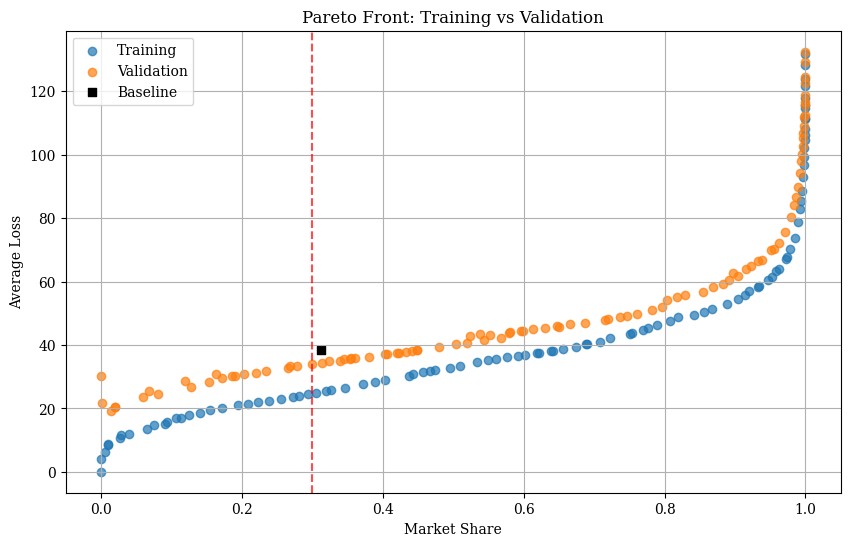

Top 5 solutions on validation set:
Solution 30: Market Share = 99.99%, Avg Loss = 129.23, Params = [ 0.97733603 -0.28703532 -0.32644279  0.19806128  0.98093386]
Solution 0: Market Share = 99.99%, Avg Loss = 132.50, Params = [ 0.93297351 -0.29152648 -0.30677526  0.20546459  0.97304817]
Solution 58: Market Share = 99.98%, Avg Loss = 124.68, Params = [ 0.97733603 -0.27685014 -0.31855285  0.19806128  0.98093386]
Solution 22: Market Share = 99.97%, Avg Loss = 122.49, Params = [ 0.89789162 -0.2869894  -0.27881225  0.23509778  0.9944749 ]
Solution 93: Market Share = 99.95%, Avg Loss = 116.51, Params = [ 0.89789162 -0.2869894  -0.15453443  0.14722656  0.9944749 ]


In [135]:


# Plot Pareto fronts for both training and validation
plt.figure(figsize=(10, 6))
plt.scatter(-res.F[:, 1], res.F[:, 0], label='Training', alpha=0.7)
plt.scatter(-val_f_values[:, 1], val_f_values[:, 0], label='Validation', alpha=0.7)
plt.xlabel('Market Share')
plt.ylabel('Average Loss')
plt.title('Pareto Front: Training vs Validation')
plt.axvline(x=0.3, color='red', linestyle='--', alpha=0.7)
plt.scatter(baseline_market_share, baseline_loss, color='black', label='Baseline', marker='s')
plt.legend()
plt.grid(True)
plt.show()

# Find best solutions on validation set
# Sort by market share (descending) and then by avg_loss (ascending)
val_indices = np.lexsort((val_f_values[:, 0], val_f_values[:, 1]))
print("Top 5 solutions on validation set:")
for idx in val_indices[:5]:
    market_share = -val_f_values[idx, 1]
    avg_loss = val_f_values[idx, 0]
    print(f"Solution {idx}: Market Share = {market_share:.2%}, Avg Loss = {avg_loss:.2f}, Params = {res.X[idx]}")


In [127]:
res.X

array([-0.31716043,  0.12593625,  0.82372706,  0.2659969 ,  0.35952261])

In [114]:
(number_of_competitors_prop,
total_claims_prop,
prediction_spread_relative_prop,
number_of_competitors_norm_switch,
prediction_spread_relative_norm_switch) = res.X

q70_pred_val = pricing_model.base_models[0.7].predict(xgb.DMatrix(X_val))
q50_pred_val = pricing_model.base_models[0.5].predict(xgb.DMatrix(X_val))
q90_pred_val = pricing_model.base_models[0.9].predict(xgb.DMatrix(X_val))
number_of_competitors_norm = X_val["number_of_competitors"] / X_val["number_of_competitors"].max()
total_claims_norm = X_val["total_claims"] / X_val["total_claims"].max()
prediction_spread_relative_norm = (q90_pred_val - q50_pred_val) / q70_pred_val

adjusted_prices = q70_pred_val*np.exp(number_of_competitors_prop*number_of_competitors_norm
                                        + total_claims_prop*total_claims_norm
                                        + prediction_spread_relative_prop*prediction_spread_relative_norm)

adjusted_prices = adjusted_prices +  1e6*(number_of_competitors_norm < number_of_competitors_norm_switch)
adjusted_prices = adjusted_prices +  1e6*(prediction_spread_relative_norm > prediction_spread_relative_norm_switch)


# Calculate metrics
has_sold = y_val > adjusted_prices
market_share = has_sold.mean()

avg_loss = (y_val[has_sold] - 
            adjusted_prices[has_sold]).mean()

print(f"Market Share: {market_share:.2%}")
print(f"Average Loss: {avg_loss:.2f}")



Market Share: 42.80%
Average Loss: 35.40


Training data shape: (62699, 52)
Test data shape: (17103, 50)


In [ ]:
# Make sure all columns are good dtypes for training

for col in train_data.columns:
    if train_data[col].dtype in ['object', 'category']:
        print(col)


quote_id


In [17]:
pricing_model = m.PricingModel()

X_train = train_data.drop(['quote_id', 'competitor_lowest_price'], axis=1)
y_train = train_data['competitor_lowest_price']

pricing_model._train_base_model(X_train, y_train)

[0]	train-mae:68.12751	val-mae:68.96272
[100]	train-mae:37.95274	val-mae:39.46297
[200]	train-mae:36.26354	val-mae:38.73773
[300]	train-mae:35.27821	val-mae:38.52641
[400]	train-mae:34.35792	val-mae:38.40738
[459]	train-mae:33.88358	val-mae:38.40443


array([[<Axes: title={'center': 'competitor_lowest_price'}>]],
      dtype=object)

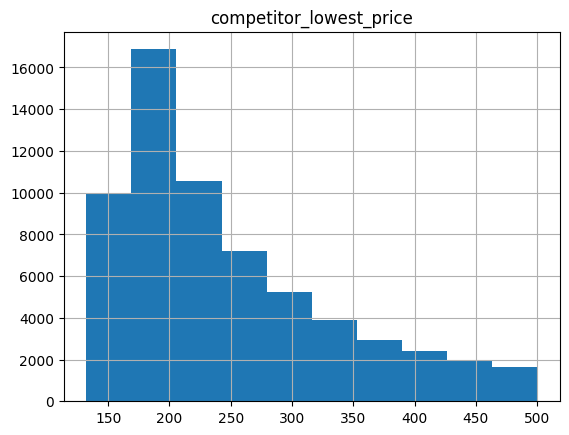

In [18]:
train_data.hist("competitor_lowest_price")

In [7]:
train_data.columns

Index(['driver_birth_date', 'driver_driving_license_ym',
       'driver_other_vehicles', 'driver_insured_years',
       'occasional_driver_birth_date',
       'occasional_driver_license_attainment_age', 'policyholder_age',
       'policyholder_license_attainment_age', 'vehicle_acquisition_state',
       'vehicle_buy_ym', 'vehicle_registration_ym', 'vehicle_engine_power',
       'vehicle_number_of_doors', 'vehicle_use', 'driver_claims_last_1_year',
       'driver_claims_from_year_1_to_2', 'driver_claims_from_year_2_to_3',
       'driver_claims_from_year_3_to_4', 'driver_claims_from_year_4_to_5',
       'timestamp', 'competitor_lowest_price', 'number_of_competitors',
       'quote_id', 'driver_age', 'vehicle_age', 'driving_experience',
       'total_claims', 'recent_claims'],
      dtype='object')

In [4]:
train_data["driver_age"].head()

KeyError: 'driver_age'